In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from policylearners import BasedGradientPolicyLearner_CIPS, CateBasedGradientPolicyLearner_CIPS
from utils import (
    generate_synthetic_data,
    softmax
    )

In [8]:
## シミュレーション設定
num_runs = 10 # シミュレーションの繰り返し回数
dim_x = 5 # 特徴量xの次元
num_actions = 2 # 行動数, |A|
beta = -0.1 # データ収集方策のパラメータ
max_iter = 5 # エポック数
test_data_size = 500 # テストデータのサイズ
random_state = 12345
torch.manual_seed(random_state)
random_ = check_random_state(random_state)
num_actions_list = [2, 10] # 行動数
num_data_list = [100, 500] # トレーニングデータのサイズ
k=1

In [9]:
result_df_data_list = []
for num_actions in num_actions_list:
    ## 期待報酬関数を定義するためのパラメータを抽出
    theta_1 = random_.normal(size=(dim_x, num_actions))
    M_1 = random_.normal(size=(dim_x, num_actions))
    b_1 = random_.normal(size=(1, num_actions))
    theta_0 = random_.normal(size=(dim_x, num_actions))
    M_0 = random_.normal(size=(dim_x, num_actions))
    b_0 = random_.normal(size=(1, num_actions))
    ## 学習された方策の真の性能を近似するためのテストデータを生成
    test_data = generate_synthetic_data(
        num_data=test_data_size, beta=beta,
        theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
        dim_context=dim_x, num_actions=num_actions, random_state = random_state,
        k=k
    )
    pi_0, q_x_a_1, q_x_a_0 = test_data["pi_0"], test_data["q_x_a_1"], test_data["q_x_a_0"]
    pi_0_value = (pi_0 * q_x_a_1 + (1. - pi_0) * q_x_a_0).sum(1).mean()

    result_df_list = []
    for num_data in num_data_list:
        test_policy_value_list = []
        for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
            ## データ収集方策が形成する分布に従いログデータを生成
            offline_logged_data = generate_synthetic_data(
                num_data=num_data, beta=beta,
                theta_1=theta_1, M_1=M_1, b_1=b_1, theta_0=theta_0, M_0=M_0, b_0=b_0,
                dim_context=dim_x, num_actions=num_actions, random_state = _,
                k=k
            )

            true_value_of_learned_policies = dict()
            true_value_of_learned_policies["logging"] = pi_0_value

            ## ログデータを用いてオフ方策学習を実行する
            ### 勾配ベースのアプローチ (IPS推定量で方策勾配を推定)
            ips = BasedGradientPolicyLearner_CIPS(
                dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
            )
            ips.fit(offline_logged_data, test_data)
            pi_ips = ips.predict(test_data)
            true_value_of_learned_policies["ips-pg"] = (pi_ips * q_x_a_1 + (1 - pi_ips) * q_x_a_0).sum(1).mean()
            ### 勾配ベースのアプローチ (新たに開発した推定量で方策勾配を推定)
            cate = CateBasedGradientPolicyLearner_CIPS(
                dim_x=dim_x, num_actions=num_actions, max_iter=max_iter, random_state=random_state + _
            )
            cate.fit(offline_logged_data, test_data)
            pi_cate = cate.predict(test_data)
            true_value_of_learned_policies["cate-pg"] = (pi_cate * q_x_a_1 + (1 - pi_cate) * q_x_a_0).sum(1).mean()

            test_policy_value_list.append(true_value_of_learned_policies)

        ## シミュレーション結果の集計
        result_df = DataFrame(test_policy_value_list).stack().reset_index(1)\
            .rename(columns={"level_1": "method", 0: "value"})
        result_df["num_data"] = num_data
        result_df["pi_0_value"] = pi_0_value
        result_df["rel_value"] = result_df["value"] / pi_0_value
        result_df_list.append(result_df)
    result_df_data_list.append(pd.concat(result_df_list).reset_index(level=0))


num_data=500...: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Font 'default' does not have a glyph for '\u30c8' [U+30c8], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u30ec' [U+30ec], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u30fc' [U+30fc], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u30cb' [U+30cb], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u30f3' [U+30f3], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u30b0' [U+30b0], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u30c7' [U+30c7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u30bf' [U+30bf], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6570' [U+6570], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u30c8' [U+30c8], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u30ec' [U+30ec], 

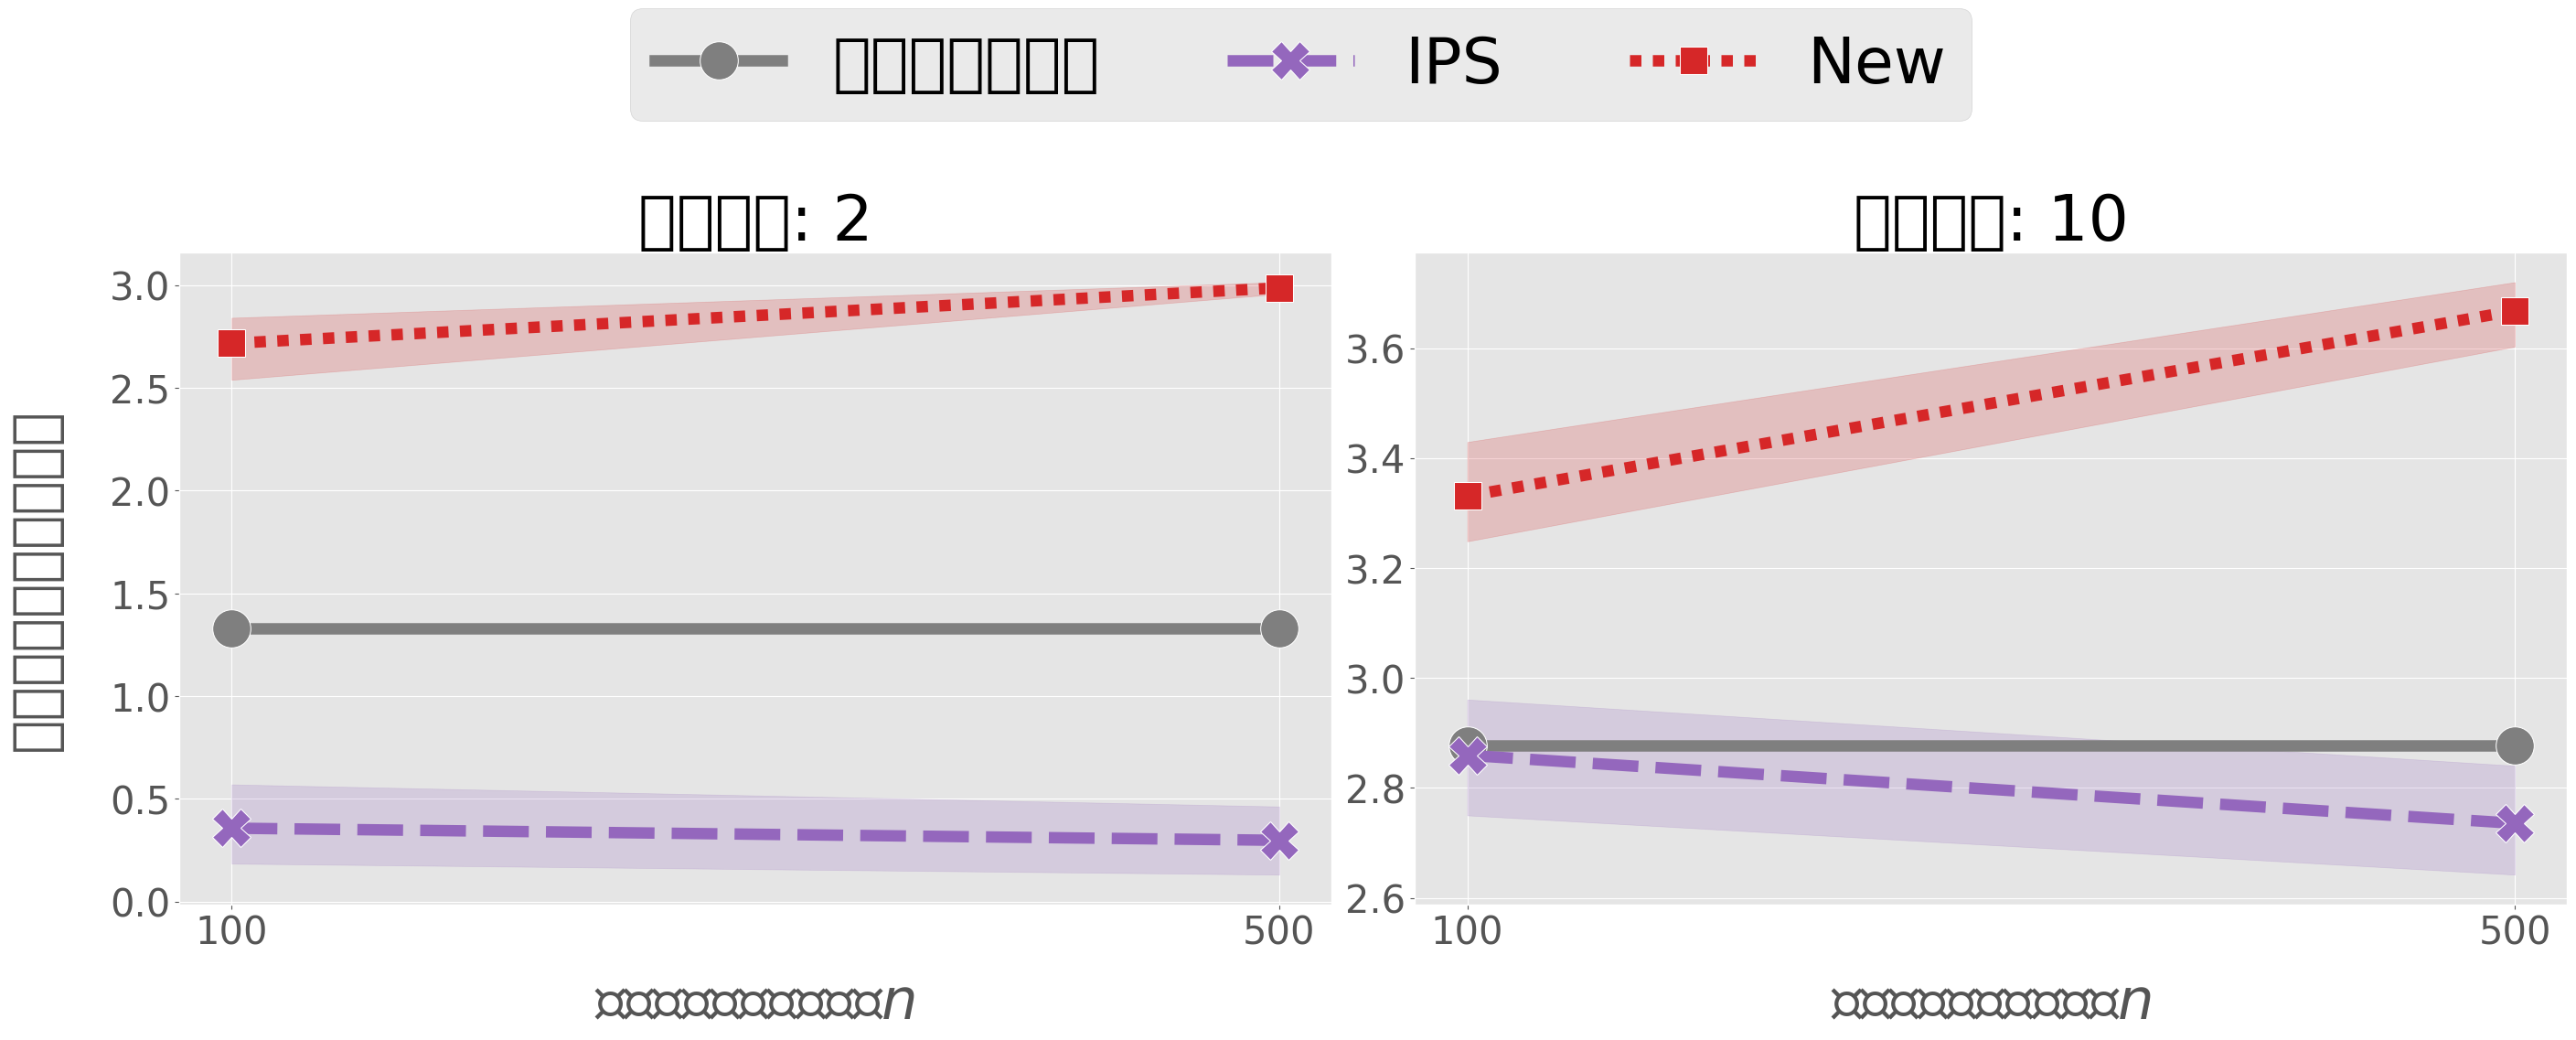

In [10]:
fig, ax_list = plt.subplots(1, 2, figsize=(28, 9.5), tight_layout=True)
for i, (num_actions, result_df) in enumerate(zip(num_actions_list, result_df_data_list)):
    ax = ax_list[i]
    sns.lineplot(
        linewidth=9,
        markersize=30,
        markers=True,
        x="num_data",
        y="value",
        hue="method",
        style="method",
        ax=ax,
        palette=["tab:grey","tab:purple", "tab:red"], # 考慮したい推定量の数だけ必要
        legend=False,
        data=result_df,
    )
    ax.set_title(f"行動の数: {num_actions}", fontsize=50)
    # yaxis
    if i == 0:
        ax.set_ylabel("学習された方策の性能", fontsize=45)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xlabel("トレーニングデータ数$n$", fontsize=45)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.11)
fig.legend(["データ収集方策", "IPS", "New"], fontsize=50, bbox_to_anchor=(0.5, 1.13), ncol=5, loc="center")
